In [1]:
!pip install qmpy-rester

In [2]:
!pip install requests pandas
import requests
import pandas as pd
import time
import json
import os

In [3]:
# --- CONFIGURATION ---
LIMIT_PER_BATCH = 50     # OQMD default limit is 50. Let's try that.
MAX_ENTRIES_TO_PULL = 5000 
FILE_NAME = 'oqmd_materials_data_final.pkl' 
BASE_URL = "http://oqmd.org/oqmdapi/formationenergy"

data_list = []
offset = 0

# --- CHECKPOINTING LOGIC ---
if os.path.exists(FILE_NAME):
    try:
        oqmd_df = pd.read_pickle(FILE_NAME)
        data_list = oqmd_df.to_dict('records')
        offset = len(data_list)
        print(f"RESUMING download. Loaded {offset} entries from {FILE_NAME}.")
    except Exception:
        print("Starting download from scratch.")


print(f"Starting direct API download. Target: {MAX_ENTRIES_TO_PULL} entries.")

# --- DIRECT API LOOP ---
while offset < MAX_ENTRIES_TO_PULL:
    try:
        params = {
            'fields': 'name,entry_id,delta_e,band_gap,natoms,sites,unit_cell',
            'filter': 'stability<0.1', # Filter for stable/near-stable materials
            'limit': LIMIT_PER_BATCH,
            'offset': offset,
            'format': 'json'          # Ensure JSON format is returned
        }
        
        # Make the request
        response = requests.get(BASE_URL, params=params)
        response.raise_for_status() # Raise an exception for bad status codes (4xx or 5xx)
        
        # Parse the JSON response
        results = response.json()
        
        # The actual data is under the 'data' key in the OQMD response format
        new_data = results.get('data', [])
        
        if not new_data:
            print("Finished fetching all available data with the current filter.")
            break
        
        data_list.extend(new_data)
        
        # Update offset based on how much data was actually returned
        offset = len(data_list)
        
        print(f"Downloaded {len(new_data)} entries. Current total: {offset}")

        # Save checkpoint
        oqmd_df = pd.DataFrame(data_list)
        oqmd_df.to_pickle(FILE_NAME)

        time.sleep(1) 

    except requests.exceptions.RequestException as e:
        print(f"Request error occurred: {e}")
        break
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        break


# --- FINAL VERIFICATION ---
oqmd_df = pd.DataFrame(data_list)
oqmd_df.to_pickle(FILE_NAME)
print(f"\nSUCCESS! Final OQMD Dataset Size: {len(oqmd_df)} entries. Saved to {FILE_NAME}.")

# Check the columns, which should now be correct
print("\n--- Verified Data Sample ---")
print(oqmd_df[['name', 'delta_e', 'band_gap', 'natoms']].head())

Starting direct API download. Target: 5000 entries.
Downloaded 50 entries. Current total: 50
Downloaded 50 entries. Current total: 100
Downloaded 50 entries. Current total: 150
Downloaded 50 entries. Current total: 200
Downloaded 50 entries. Current total: 250
Downloaded 50 entries. Current total: 300
Downloaded 50 entries. Current total: 350
Downloaded 50 entries. Current total: 400
Downloaded 50 entries. Current total: 450
Downloaded 50 entries. Current total: 500
Downloaded 50 entries. Current total: 550
Downloaded 50 entries. Current total: 600
Downloaded 50 entries. Current total: 650
Downloaded 50 entries. Current total: 700
Downloaded 50 entries. Current total: 750
Downloaded 50 entries. Current total: 800
Downloaded 50 entries. Current total: 850
Downloaded 50 entries. Current total: 900
Downloaded 50 entries. Current total: 950
Downloaded 50 entries. Current total: 1000
Downloaded 50 entries. Current total: 1050
Downloaded 50 entries. Current total: 1100
Downloaded 50 entries.

In [4]:
!pip install pymatgen

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 82.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.0/809.0 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 2.1 MB/s eta 0:00:00
  Created wheel for bibtexparser: filename=bibtexparser-1.4.3-py3-none-any.whl size=43549 sha256=f507100fc0b796f83417108e935082722abf389f3c9b2ae9f97f97cbdc8d5c30
  Stored in directory: /root/.cache/pip/wheels/16/fb/76/306387739cf9d53b1c39b0c8aadbbb17dc05f256756d8fd915
Successfully built bibtexparser
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.2
    Uninstalling matp

In [5]:
# Diagnostic + conversion cell: run in your Kaggle notebook
import os, ast, json, re
import pandas as pd
from tqdm import tqdm
from pymatgen.core import Structure, Lattice

# ------------- load DF (try final then fallback) -------------
paths = [
    "/kaggle/working/oqmd_materials_data_final.pkl",
    "/kaggle/working/oqmd_materials_data.pkl",
    "./oqmd_materials_data_final.pkl",
    "./oqmd_materials_data.pkl"
]
df = None
for p in paths:
    if os.path.exists(p):
        try:
            df = pd.read_pickle(p)
            print(f"Loaded dataframe from: {p}")
            break
        except Exception as e:
            print(f"Found file {p} but failed to load pickle: {e}")

if df is None:
    raise FileNotFoundError("No pickle file found at expected locations. Make sure the pickle exists.")

# ------------- quick summary -------------
print("\nDataFrame summary:")
print("Rows:", len(df))
print("Columns:", df.columns.tolist())
print("\nColumn dtypes:")
print(df.dtypes)

# ------------- inspect 'sites' & 'unit_cell' types -------------
def type_counts(col):
    types = df[col].map(lambda x: type(x).__name__ if x is not None else "None")
    return types.value_counts().to_dict()

if 'sites' in df.columns:
    print("\nType distribution for 'sites':", type_counts('sites'))
else:
    print("\nColumn 'sites' not found!")

if 'unit_cell' in df.columns:
    print("Type distribution for 'unit_cell':", type_counts('unit_cell'))
else:
    print("Column 'unit_cell' not found!")

print("\nSample raw values (first 8 rows):")
sample_cols = [c for c in ['entry_id','sites','unit_cell'] if c in df.columns]
print(df[sample_cols].head(8).to_string(index=False))

# ------------- parsing helpers -------------

SITE_RE = re.compile(
    r'([A-Z][a-z]?\d{0,2})\s*@\s*([+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)\s+([+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)\s+([+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)'
)

def parse_unit_cell(unit_cell_raw):
    if unit_cell_raw is None:
        return None
    if isinstance(unit_cell_raw, (list, tuple)):
        return unit_cell_raw
    if isinstance(unit_cell_raw, str):
        for fn in (json.loads, ast.literal_eval):
            try:
                val = fn(unit_cell_raw)
                if isinstance(val, (list, tuple)):
                    return val
            except:
                pass
        return None
    return None

def normalize_sites_to_string(sites_raw):
    if sites_raw is None:
        return ""
    if isinstance(sites_raw, bytes):
        try:
            s = sites_raw.decode("utf-8", errors="ignore")
        except:
            s = str(sites_raw)
    elif isinstance(sites_raw, (list, tuple)):
        s = ", ".join([str(x) for x in sites_raw])
    else:
        s = str(sites_raw)
    s = s.strip()
    if s.startswith("[") and s.endswith("]"):
        s = s[1:-1].strip()
    s = s.replace("'", "").replace('"', "")
    return s

def try_build_structure(row):
    try:
        unit_cell_raw = row.get("unit_cell", None)
        sites_raw = row.get("sites", None)
        unit_cell = parse_unit_cell(unit_cell_raw)
        sites_s = normalize_sites_to_string(sites_raw)
        if not unit_cell:
            return None, "unit_cell_missing_or_unparseable"
        if not sites_s:
            return None, "sites_missing_or_unparseable"
        matches = SITE_RE.findall(sites_s)
        if not matches:
            return None, "no_site_regex_matches"
        species = []
        coords = []
        max_coord = 0.0
        for m in matches:
            el = m[0]
            x, y, z = float(m[1]), float(m[2]), float(m[3])
            species.append(el)
            coords.append([x, y, z])
            max_coord = max(max_coord, abs(x), abs(y), abs(z))
        coords_are_cartesian = max_coord > 1.5  # heuristic
        lattice = Lattice(unit_cell)
        struct = Structure(lattice, species, coords, coords_are_cartesian=coords_are_cartesian)
        return struct, None
    except Exception as e:
        return None, f"exception:{type(e).__name__}:{str(e)[:200]}"

# ------------- diagnose rows -------------
converted = []
failures = []
failure_examples = []

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Diagnosing rows"):
    struct, reason = try_build_structure(row)
    if struct is None:
        failures.append(reason)
        converted.append(None)
        if len(failure_examples) < 20:
            failure_examples.append({
                "index": idx,
                "entry_id": row.get("entry_id"),
                "sites_type": type(row.get("sites")).__name__ if 'sites' in row else None,
                "unit_cell_type": type(row.get("unit_cell")).__name__ if 'unit_cell' in row else None,
                "sites_repr": str(row.get("sites"))[:300],
                "unit_cell_repr": str(row.get("unit_cell"))[:300],
                "reason": reason
            })
    else:
        failures.append(None)
        converted.append(struct)

# ------------- results -------------
n_total = len(df)
n_success = sum(1 for x in converted if x is not None)
pct = (100.0 * n_success / n_total) if n_total > 0 else 0.0

print(f"\nConverted {n_success} / {n_total} structures ({pct:.1f}%).")

# ------------- failure summary -------------
from collections import Counter
reason_counts = Counter([r for r in failures if r])
print("\nFailure reason counts:")
for r, c in reason_counts.most_common():
    print(f"{r}: {c}")

print("\nFailure examples (up to 20):")
for ex in failure_examples:
    print("\n---")
    for k,v in ex.items():
        print(f"{k}: {v}")

# ------------- save successful only -------------
df['structure_obj'] = converted
if n_success > 0:
    df_clean = df[df['structure_obj'].notnull()].reset_index(drop=True)
    out_path = "/kaggle/working/oqmd_materials_data_final_structures_diagnostic.pkl"
    df_clean.to_pickle(out_path)
    print(f"\nSaved cleaned data with {len(df_clean)} structures → {out_path}")
else:
    print("\nNo structures succeeded; nothing saved.")


Loaded dataframe from: /kaggle/working/oqmd_materials_data_final.pkl

DataFrame summary:
Rows: 5000
Columns: ['name', 'entry_id', 'natoms', 'unit_cell', 'sites', 'band_gap', 'delta_e']

Column dtypes:
name          object
entry_id       int64
natoms         int64
unit_cell     object
sites         object
band_gap     float64
delta_e      float64
dtype: object

Type distribution for 'sites': {'list': 5000}
Type distribution for 'unit_cell': {'list': 5000}

Sample raw values (first 8 rows):
 entry_id                                                        sites                                                                                             unit_cell
  1216058 [Lu @ 0 0 0, Lu @ 0.778 0.222 0.334, Lu @ 0.222 0.778 0.666]                  [[-1.733802, 3.003035, 0.0], [3.467606, 0.0, 0.0], [1.733802, -1.001012, -8.292372]]
  1216098 [Tm @ 0 0 0, Tm @ 0.222 0.778 0.334, Tm @ 0.778 0.222 0.666]                   [[1.747609, -3.026948, 0.0], [1.747609, 3.026948, 0.0], [0.0, -2.017965

Diagnosing rows: 100%|██████████| 5000/5000 [00:00<00:00, 6960.35it/s]



Converted 5000 / 5000 structures (100.0%).

Failure reason counts:

Failure examples (up to 20):

Saved cleaned data with 5000 structures → /kaggle/working/oqmd_materials_data_final_structures_diagnostic.pkl


In [6]:
import pandas as pd

df = pd.read_pickle("/kaggle/working/oqmd_materials_data_final_structures_diagnostic.pkl")
df.head()


,name,entry_id,natoms,unit_cell,sites,band_gap,delta_e,structure_obj
0,Lu,1216058,3,"[[-1.733802, 3.003035, 0.0], [3.467606, 0.0, 0...","[Lu @ 0 0 0, Lu @ 0.778 0.222 0.334, Lu @ 0.22...",0.000,0.012590,"[[0. 0. 0.] Lu, [ 4.44000000e-07 2.00202322e+..."
1,Tm,1216098,3,"[[1.747609, -3.026948, 0.0], [1.747609, 3.0269...","[Tm @ 0 0 0, Tm @ 0.222 0.778 0.334, Tm @ 0.77...",0.000,0.006394,"[[0. 0. 0.] Tm, [1.747609 1.00898278 2.79740..."
2,Ne,4698,1,"[[2.2145, -2.2145, 0.0], [-2.2145, 0.0, -2.214...",[Ne @ 0 0 0],11.910,0.000137,[[0. 0. 0.] Ne]
3,Kr,8203,1,"[[2.776996, -2.776996, 0.0], [-2.776996, 0.0, ...",[Kr @ 0 0 0],7.487,0.002735,[[0. 0. 0.] Kr]
4,Rb,8533,1,"[[2.818906, 2.818906, 2.818906], [2.818906, -2...",[Rb @ 0 0 0],0.000,0.000720,[[0. 0. 0.] Rb]


In [7]:
from sklearn.model_selection import train_test_split

# Drop rows that failed structure conversion (though you likely already did this)
df.dropna(subset=['structure_obj'], inplace=True)

# 1. Split out the test set (10%) first
train_val_df, test_df = train_test_split(
    df, test_size=0.1, random_state=42, shuffle=True
)

# 2. Split the remaining data into train (80%) and validation (10%)
# (80% of 90% is 78%, 10% of 90% is 9%, resulting in approx 80/10/10 split)
train_df, val_df = train_test_split(
    train_val_df, test_size=(1/9), random_state=42, shuffle=True
)

print(f"Total entries: {len(df)}")
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Total entries: 5000
Training set size: 4000
Validation set size: 500
Test set size: 500


In [8]:
from sklearn.preprocessing import StandardScaler

# Initialize two separate scalers for the two properties
scaler_delta_e = StandardScaler()
scaler_band_gap = StandardScaler()

# --- A. Fit and Transform the Training Data ---
train_df['delta_e_scaled'] = scaler_delta_e.fit_transform(train_df[['delta_e']])
train_df['band_gap_scaled'] = scaler_band_gap.fit_transform(train_df[['band_gap']])

# --- B. Transform the Validation and Test Data (using ONLY the training set's mean/std) ---
val_df['delta_e_scaled'] = scaler_delta_e.transform(val_df[['delta_e']])
val_df['band_gap_scaled'] = scaler_band_gap.transform(val_df[['band_gap']])

test_df['delta_e_scaled'] = scaler_delta_e.transform(test_df[['delta_e']])
test_df['band_gap_scaled'] = scaler_band_gap.transform(test_df[['band_gap']])

print("\nTargets scaled using training set statistics. Ready for featurization.")

# IMPORTANT: Save the scalers! You need them to un-scale the predictions 
# when calculating the final MAE (Mean Absolute Error) for your comparison study.
import joblib
joblib.dump(scaler_delta_e, 'scaler_delta_e.pkl')
joblib.dump(scaler_band_gap, 'scaler_band_gap.pkl')


Targets scaled using training set statistics. Ready for featurization.


['scaler_band_gap.pkl']

In [9]:
# Check the columns in the training set
print("--- Training Data Column Check ---")
print(train_df.columns)

# Check a sample row to ensure the structure object is still there
print("\n--- Sample Structure Object ---")
print(train_df['structure_obj'].iloc[0])

--- Training Data Column Check ---
Index(['name', 'entry_id', 'natoms', 'unit_cell', 'sites', 'band_gap',
       'delta_e', 'structure_obj', 'delta_e_scaled', 'band_gap_scaled'],
      dtype='object')

--- Sample Structure Object ---
Full Formula (Zr1 Ni2 P2)
Reduced Formula: Zr(NiP)2
abc   :   3.713822   3.713822   5.423961
angles: 110.020314 110.020314  90.000000
pbc   :       True       True       True
Sites (5)
  #  SP        a      b      c
---  ----  -----  -----  -----
  0  Ni    0.75   0.25   0.5
  1  Ni    0.25   0.75   0.5
  2  P     0.618  0.618  0.237
  3  P     0.382  0.382  0.763
  4  Zr    0      0      0


In [10]:
# Check scaled targets for the Training Set (where the scaler was fitted)
print("\n--- Scaled Target Statistics (Training Set) ---")
print(train_df[['delta_e_scaled', 'band_gap_scaled']].agg(['mean', 'std']))

# Check scaled targets for the Validation Set (should also be close to 0/1)
print("\n--- Scaled Target Statistics (Validation Set) ---")
print(val_df[['delta_e_scaled', 'band_gap_scaled']].agg(['mean', 'std']))


--- Scaled Target Statistics (Training Set) ---
      delta_e_scaled  band_gap_scaled
mean   -1.318945e-16    -8.881784e-17
std     1.000125e+00     1.000125e+00

--- Scaled Target Statistics (Validation Set) ---
      delta_e_scaled  band_gap_scaled
mean       -0.012379        -0.046135
std         1.009664         0.858038


In [11]:
!pip install torch-geometric torch numpy scipy

import numpy as np
import torch
from torch_geometric.data import Data, DataLoader
from tqdm import tqdm
from pymatgen.core.periodic_table import Element

# =========================
# Atom Features
# =========================
def get_atom_features_from_site(site):
    try:
        elem = site.specie.element
    except:
        elem = site.specie

    Z = float(getattr(elem, "Z", 0.0))
    group = float(getattr(elem, "group", 0.0) or 0.0)
    period = float(getattr(elem, "row", 0.0) or getattr(elem, "period", 0.0) or 0.0)
    atomic_mass = float(getattr(elem, "atomic_mass", 0.0) or 0.0)
    atomic_radius = float(getattr(elem, "atomic_radius", 0.0) or 0.0)

    return np.array([Z, group, period, atomic_mass, atomic_radius], dtype=float)

# =========================
# RBF bond features
# =========================
def rbf_expand(distances, cutoff=12.0, n_gaussians=32):
    distances = np.asarray(distances, dtype=float).reshape(-1,1)
    centers = np.linspace(0, cutoff, n_gaussians)
    sigma = centers[1] - centers[0]
    return np.exp(-((distances - centers)**2) / (2 * sigma**2))


# =========================
# Single graph builder
# =========================
def featurize_to_pyg(row, cutoff=12.0, n_gaussians=32):
    struct = row["structure_obj"]

    # ----- Targets -----
    y = np.array([row["delta_e_scaled"], row["band_gap_scaled"]], dtype=float)

    # ----- Node features -----
    x = np.array([get_atom_features_from_site(site) for site in struct], dtype=float)
    if len(x) == 0:
        return None

    # ----- Neighbors -----
    neighbors = struct.get_all_neighbors(cutoff, include_image=True)

    edge_index = []
    edge_distances = []

    for i, neigh_list in enumerate(neighbors):
        for neigh in neigh_list:
            try:
                d = neigh.distance() if callable(neigh.distance) else float(neigh.distance)
            except:
                continue

            if i == neigh.index and abs(d) < 1e-6:
                continue

            edge_index.append([i, neigh.index])
            edge_distances.append(d)

    # Fallback: if still no edges
    if len(edge_index) == 0:
        for i in range(len(struct)):
            for j in range(len(struct)):
                if i == j:
                    continue
                d = struct.get_distance(i, j, jimage=None)
                if d < cutoff:
                    edge_index.append([i, j])
                    edge_distances.append(d)

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(rbf_expand(edge_distances, cutoff, n_gaussians), dtype=torch.float)

    data = Data(
        x=torch.tensor(x, dtype=torch.float),
        edge_index=edge_index,
        edge_attr=edge_attr,
        y=torch.tensor(y, dtype=torch.float)
    )
    return data

# =========================
# Build graph lists
# =========================
def build_graph_list(df):
    graphs = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Featurizing"):
        g = featurize_to_pyg(row)
        if g is not None:
            graphs.append(g)
    return graphs

train_graphs = build_graph_list(train_df)
val_graphs   = build_graph_list(val_df)
test_graphs  = build_graph_list(test_df)

print("\nGraph counts:")
print("Train:", len(train_graphs))
print("Val  :", len(val_graphs))
print("Test :", len(test_graphs))

# =========================
# DataLoaders
# =========================
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_graphs, batch_size=32)
test_loader  = DataLoader(test_graphs, batch_size=32)

print("Done!")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

Featurizing: 100%|██████████| 500/500 [00:06<00:00, 76.32it/s]


Graph counts:
Train: 4000
Val  : 500
Test : 500
Done!



/tmp/ipykernel_19/2282536505.py:114: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
/tmp/ipykernel_19/2282536505.py:115: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  val_loader   = DataLoader(val_graphs, batch_size=32)
/tmp/ipykernel_19/2282536505.py:116: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  test_loader  = DataLoader(test_graphs, batch_size=32)


In [12]:
print("train_df columns:", train_df.columns.tolist())
print("val_df columns:", val_df.columns.tolist())
print("test_df columns:", test_df.columns.tolist())

print("\nNumber of missing structure_obj:")
print("train:", train_df['structure_obj'].isna().sum())
print("val  :", val_df['structure_obj'].isna().sum())
print("test :", test_df['structure_obj'].isna().sum())

print("\nFirst few structure objects:")
print(train_df['structure_obj'].head())


train_df columns: ['name', 'entry_id', 'natoms', 'unit_cell', 'sites', 'band_gap', 'delta_e', 'structure_obj', 'delta_e_scaled', 'band_gap_scaled']
val_df columns: ['name', 'entry_id', 'natoms', 'unit_cell', 'sites', 'band_gap', 'delta_e', 'structure_obj', 'delta_e_scaled', 'band_gap_scaled']
test_df columns: ['name', 'entry_id', 'natoms', 'unit_cell', 'sites', 'band_gap', 'delta_e', 'structure_obj', 'delta_e_scaled', 'band_gap_scaled']

Number of missing structure_obj:
train: 0
val  : 0
test : 0

First few structure objects:
2619    [[-1.856911   0.         2.3729265] Ni, [ 0.  ...
4918    [[0. 0. 0.] Fe, [ 1.97912555e+00  1.59031000e-...
1678    [[0. 0. 0.] Sc, [-2.50534793e-17 -4.89474126e+...
3221    [[0. 0. 0.] K, [0.       0.       5.096044] K,...
1291    [[ 1.739282  1.004175 -3.242695] Dy, [ 1.73928...
Name: structure_obj, dtype: object


In [13]:
# 1) Are all structure_obj instances actually pymatgen Structure?
from pymatgen.core.structure import Structure
print("All train structures are Structure objects:", train_df['structure_obj'].apply(lambda s: isinstance(s, Structure)).all())

# 2) Do natoms match the number of sites in the Structure?
mismatch = train_df.apply(lambda r: r['natoms'] != len(r['structure_obj']), axis=1).sum()
print("Train natoms != len(structure_obj):", mismatch)

# 3) Quick lattice sanity: positive volume and non-degenerate
bad_vol = train_df['structure_obj'].apply(lambda s: s.lattice.volume <= 1e-6).sum()
print("Train degenerate lattices (volume <= 1e-6):", bad_vol)


All train structures are Structure objects: True
Train natoms != len(structure_obj): 0
Train degenerate lattices (volume <= 1e-6): 0


In [14]:
import os, time, joblib, random
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
from sklearn.metrics import mean_absolute_error

from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv, global_mean_pool

# --------------------
# Repro / device
# --------------------
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --------------------
# Hyperparams
# --------------------
BATCH_SIZE = 32
LR = 1e-3
EPOCHS = 80
HIDDEN = 128
EDGE_MLP_HIDDEN = 128
OUT_CH = 2
PATIENCE = 15
WEIGHT_DECAY = 1e-6

# --------------------
# Load scalers
# --------------------
# Ensure these files exist in your current directory
try:
    scaler_delta_e = joblib.load("scaler_delta_e.pkl")
    scaler_band_gap = joblib.load("scaler_band_gap.pkl")
except FileNotFoundError:
    print("Warning: Scalers not found. Make sure pickle files are in the directory.")

def inverse_scale_preds(preds):
    d_pred = scaler_delta_e.inverse_transform(preds[:, 0].reshape(-1,1)).ravel()
    b_pred = scaler_band_gap.inverse_transform(preds[:, 1].reshape(-1,1)).ravel()
    return np.vstack([d_pred, b_pred]).T

# --------------------
# Sanity: graphs present
# --------------------
# Assuming train_graphs, val_graphs, test_graphs are already in memory
# If copying this script to a new file, you might need to load your .pkl data here first.
if 'train_graphs' not in globals():
    # Placeholder for safety if running standalone without previous cells
    print("WARNING: train_graphs not found in globals. Ensure data is loaded.")
else:
    print("Graph counts (in-memory):", len(train_graphs), len(val_graphs), len(test_graphs))

# --------------------
# Dataloaders
# --------------------
if 'train_graphs' in globals():
    train_loader = DataLoader(train_graphs, batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(val_graphs, batch_size=BATCH_SIZE, shuffle=False)
    test_loader  = DataLoader(test_graphs, batch_size=BATCH_SIZE, shuffle=False)

# --------------------
# Correct EdgeNN & NNConvGNN
# --------------------
class EdgeNN(nn.Module):
    def __init__(self, edge_in, node_in, node_out, hidden=EDGE_MLP_HIDDEN):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(edge_in, hidden),
            nn.SiLU(),
            nn.Linear(hidden, node_in * node_out)
        )
    
    def forward(self, edge_attr):
        return self.net(edge_attr) 

class NNConvGNN(nn.Module):
    def __init__(self, node_in, edge_in, hidden=HIDDEN, num_layers=3, out_dim=OUT_CH):
        super().__init__()
        self.embed_in = nn.Linear(node_in, hidden)
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        
        for i in range(num_layers):
            # NNConv expects the NN to output (in_channels * out_channels)
            edge_net = EdgeNN(edge_in=edge_in, node_in=hidden, node_out=hidden, hidden=EDGE_MLP_HIDDEN)
            conv = NNConv(in_channels=hidden, out_channels=hidden, nn=edge_net, aggr='mean')
            self.convs.append(conv)
            self.bns.append(nn.BatchNorm1d(hidden))
            
        self.pool = global_mean_pool
        self.head = nn.Sequential(
            nn.Linear(hidden, hidden),
            nn.SiLU(),
            nn.Linear(hidden, out_dim)
        )
        
    def forward(self, x, edge_index, edge_attr, batch):
        h = self.embed_in(x)
        for conv, bn in zip(self.convs, self.bns):
            h = conv(h, edge_index, edge_attr)
            h = bn(h)
            h = torch.relu(h)
        
        g = self.pool(h, batch)
        out = self.head(g)
        return out

# --------------------
# Instantiate model
# --------------------
if 'train_graphs' in globals():
    sample = train_graphs[0]
    node_in_dim = sample.x.shape[1]
    edge_in_dim = sample.edge_attr.shape[1]
    print("Node dim:", node_in_dim, "Edge dim:", edge_in_dim)

    model = NNConvGNN(node_in=node_in_dim, edge_in=edge_in_dim, hidden=HIDDEN, num_layers=3, out_dim=OUT_CH).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    criterion = nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    # --------------------
    # Training loop
    # --------------------
    best_val_mae = float('inf')
    best_epoch = -1
    save_path = "nnconv_best.pt"
    start_time = time.time()
    no_improve = 0
    
    import csv
    logfile = "nnconv_training_log.csv"
    with open(logfile, "w") as fh:
        writer = csv.writer(fh)
        writer.writerow(["epoch","train_mse","val_mae","elapsed_sec","lr"])

    print(f"Starting training on {DEVICE}...")

    for epoch in range(1, EPOCHS+1):
        model.train()
        train_loss = 0.0
        n_seen = 0
        
        for batch in train_loader:
            optimizer.zero_grad()
            batch = batch.to(DEVICE)
            
            out = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch) # (B, 2)
            
            # --- FIX HERE: Reshape batch.y to match (Batch, 2) ---
            target = batch.y.view(-1, 2) 
            
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()
            
            train_loss += float(loss.item()) * out.shape[0]
            n_seen += out.shape[0]
        
        train_loss = train_loss / max(1, n_seen)

        # validate
        model.eval()
        preds = []
        trues = []
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(DEVICE)
                out = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
                
                preds.append(out.cpu().numpy())
                
                # --- FIX HERE: Also reshape for validation collection ---
                trues.append(batch.y.view(-1, 2).cpu().numpy())
                
        if preds:
            preds = np.vstack(preds)
            trues = np.vstack(trues)
            preds_orig = inverse_scale_preds(preds)
            trues_orig = inverse_scale_preds(trues)
            val_mae = mean_absolute_error(trues_orig, preds_orig)
        else:
            val_mae = float('inf')

        elapsed = time.time() - start_time
        # Handle LR access safely
        current_lr = optimizer.param_groups[0]['lr']
        
        print(f"Epoch {epoch:03d} | Train MSE: {train_loss:.6f} | Val MAE (orig): {val_mae:.6f} | elapsed {elapsed:.0f}s | lr {current_lr:.2e}")

        with open(logfile, "a") as fh:
            writer = csv.writer(fh)
            writer.writerow([epoch, train_loss, val_mae, int(elapsed), current_lr])

        scheduler.step(val_mae)

        # early stopping / save
        if val_mae < best_val_mae:
            best_val_mae = val_mae
            best_epoch = epoch
            torch.save(model.state_dict(), save_path)
            print(f"   -> Saved best (epoch {epoch}, val_mae {val_mae:.6f})")
            no_improve = 0
        else:
            no_improve += 1

        if no_improve >= PATIENCE:
            print(f"Early stopping (no improvement for {PATIENCE} epochs).")
            break

    print(f"Training complete. Best val MAE={best_val_mae:.6f} at epoch {best_epoch}. Model saved to {save_path}")

    # --------------------
    # Final test evaluation
    # --------------------
    model.load_state_dict(torch.load(save_path, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(DEVICE)
            out = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            preds.append(out.cpu().numpy())
            # --- FIX HERE: Reshape test targets too ---
            trues.append(batch.y.view(-1, 2).cpu().numpy())

    preds = np.vstack(preds)
    trues = np.vstack(trues)
    preds_orig = inverse_scale_preds(preds)
    trues_orig = inverse_scale_preds(trues)
    test_mae = mean_absolute_error(trues_orig, preds_orig)
    print(f"Final Test MAE (orig units): {test_mae:.6f}")

Graph counts (in-memory): 4000 500 500
Node dim: 5 Edge dim: 32
Starting training on cuda...
Epoch 001 | Train MSE: 0.700963 | Val MAE (orig): 0.446046 | elapsed 3s | lr 1.00e-03
   -> Saved best (epoch 1, val_mae 0.446046)
Epoch 002 | Train MSE: 0.551805 | Val MAE (orig): 0.398193 | elapsed 5s | lr 1.00e-03
   -> Saved best (epoch 2, val_mae 0.398193)
Epoch 003 | Train MSE: 0.467553 | Val MAE (orig): 0.344999 | elapsed 6s | lr 1.00e-03
   -> Saved best (epoch 3, val_mae 0.344999)
Epoch 004 | Train MSE: 0.401986 | Val MAE (orig): 0.352247 | elapsed 8s | lr 1.00e-03
Epoch 005 | Train MSE: 0.362703 | Val MAE (orig): 0.324738 | elapsed 10s | lr 1.00e-03
   -> Saved best (epoch 5, val_mae 0.324738)
Epoch 006 | Train MSE: 0.320181 | Val MAE (orig): 0.281079 | elapsed 12s | lr 1.00e-03
   -> Saved best (epoch 6, val_mae 0.281079)
Epoch 007 | Train MSE: 0.328306 | Val MAE (orig): 0.286340 | elapsed 14s | lr 1.00e-03
Epoch 008 | Train MSE: 0.279141 | Val MAE (orig): 0.282923 | elapsed 15s | lr

Delta E  | MAE: 0.1440 eV/atom | R2: 0.9076
Band Gap | MAE: 0.2177 eV      | R2: 0.7919


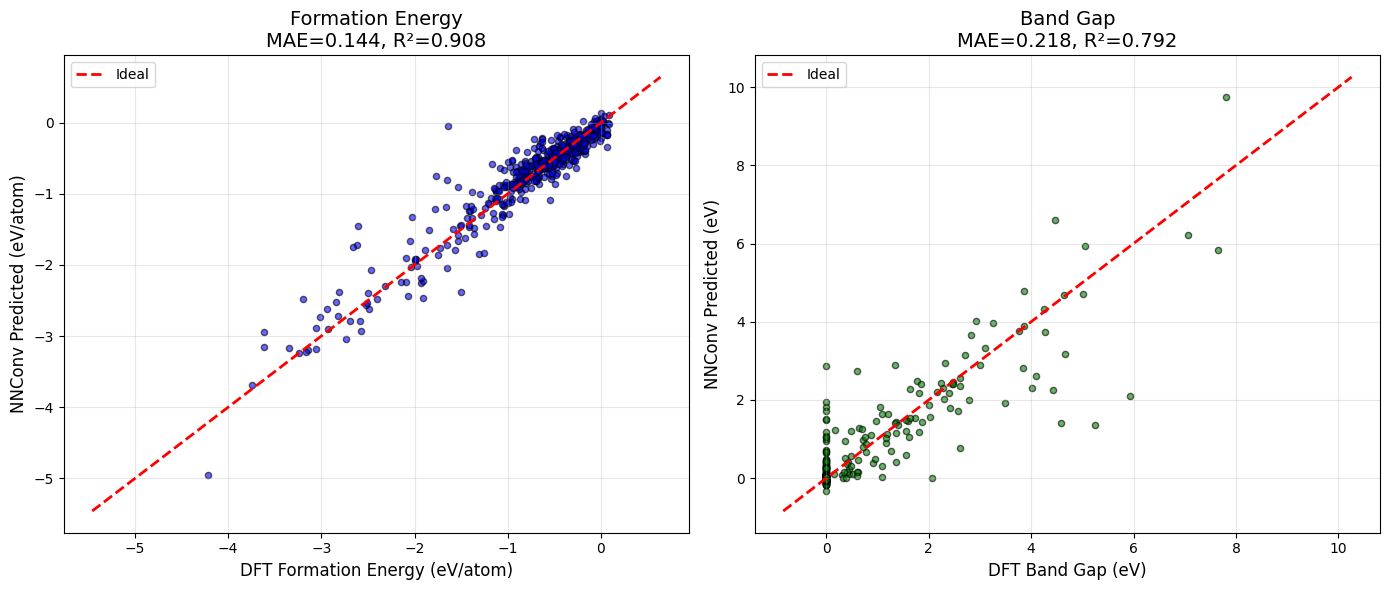

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# --------------------
# 1. Get per-target metrics
# --------------------
# trues_orig and preds_orig come from the end of your previous script
mae_delta_e = mean_absolute_error(trues_orig[:, 0], preds_orig[:, 0])
mae_band_gap = mean_absolute_error(trues_orig[:, 1], preds_orig[:, 1])

r2_delta_e = r2_score(trues_orig[:, 0], preds_orig[:, 0])
r2_band_gap = r2_score(trues_orig[:, 1], preds_orig[:, 1])

print(f"Delta E  | MAE: {mae_delta_e:.4f} eV/atom | R2: {r2_delta_e:.4f}")
print(f"Band Gap | MAE: {mae_band_gap:.4f} eV      | R2: {r2_band_gap:.4f}")

# --------------------
# 2. Plotting
# --------------------
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# --- Plot 1: Formation Energy ---
# Scatter points
ax[0].scatter(trues_orig[:, 0], preds_orig[:, 0], alpha=0.6, c='blue', edgecolors='k', s=20)
# Ideal line (y=x)
min_val = min(trues_orig[:, 0].min(), preds_orig[:, 0].min()) - 0.5
max_val = max(trues_orig[:, 0].max(), preds_orig[:, 0].max()) + 0.5
ax[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Ideal')

ax[0].set_xlabel("DFT Formation Energy (eV/atom)", fontsize=12)
ax[0].set_ylabel("NNConv Predicted (eV/atom)", fontsize=12)
ax[0].set_title(f"Formation Energy\nMAE={mae_delta_e:.3f}, R²={r2_delta_e:.3f}", fontsize=14)
ax[0].legend()
ax[0].grid(True, alpha=0.3)

# --- Plot 2: Band Gap ---
ax[1].scatter(trues_orig[:, 1], preds_orig[:, 1], alpha=0.6, c='green', edgecolors='k', s=20)
min_val = min(trues_orig[:, 1].min(), preds_orig[:, 1].min()) - 0.5
max_val = max(trues_orig[:, 1].max(), preds_orig[:, 1].max()) + 0.5
ax[1].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Ideal')

ax[1].set_xlabel("DFT Band Gap (eV)", fontsize=12)
ax[1].set_ylabel("NNConv Predicted (eV)", fontsize=12)
ax[1].set_title(f"Band Gap\nMAE={mae_band_gap:.3f}, R²={r2_band_gap:.3f}", fontsize=14)
ax[1].legend()
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("parity_plot_nnconv.png", dpi=300)
plt.show()

FINAL MODEL EVALUATION REPORT
Model Architecture: NNConvGNN
Total Parameters:   6,421,122
Trainable Params:   6,421,122
------------------------------------------------------------
COMPUTATIONAL EFFICIENCY
Training Time:      2.4 min total
Inference Speed:    0.22 ms/sample (Batch Size 32)
------------------------------------------------------------
DATA STATISTICS (Test Set Avg)
Avg Atoms/Crystal:  4.5
Avg Bonds/Crystal:  18.7
------------------------------------------------------------
ACCURACY METRICS
                    Target    MAE   RMSE     R2
Formation Energy (eV/atom) 0.1440 0.2212 0.9076
             Band Gap (eV) 0.2177 0.5226 0.7919


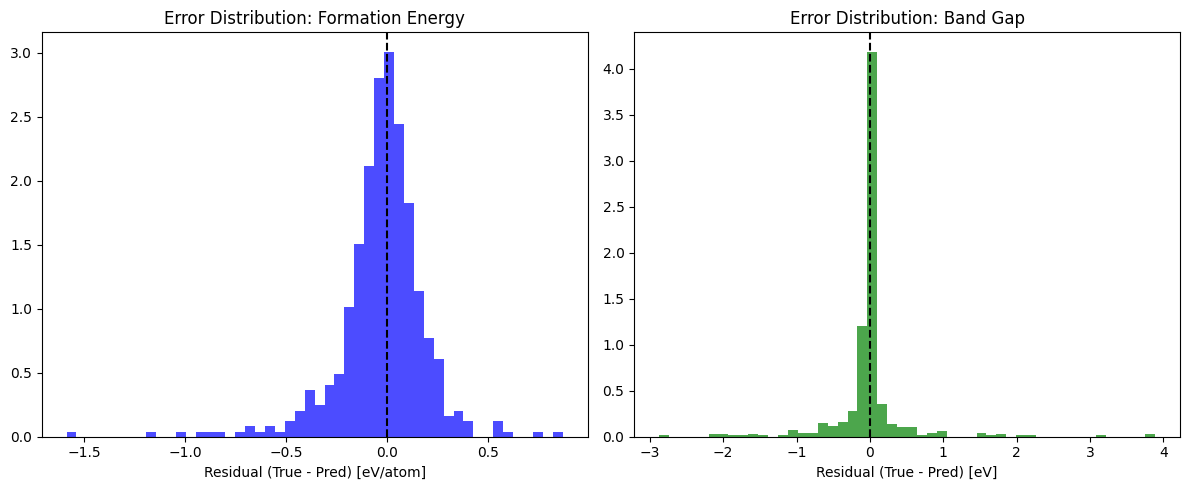

In [16]:
import numpy as np
import pandas as pd
import time
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1. Accuracy Metrics (MAE, RMSE, R2)
# ---------------------------------------------------------
def get_metrics(y_true, y_pred, label):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {"Target": label, "MAE": mae, "RMSE": rmse, "R2": r2}

# Calculate for Formation Energy (Column 0)
m_delta = get_metrics(trues_orig[:, 0], preds_orig[:, 0], "Formation Energy (eV/atom)")

# Calculate for Band Gap (Column 1)
m_band = get_metrics(trues_orig[:, 1], preds_orig[:, 1], "Band Gap (eV)")

# Create DataFrame
df_metrics = pd.DataFrame([m_delta, m_band])

# ---------------------------------------------------------
# 2. Computational Metrics (Parameters & Timing)
# ---------------------------------------------------------
# A. Parameter Count
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# B. Training Speed (from log file)
try:
    df_log = pd.read_csv("nnconv_training_log.csv")
    avg_epoch_time = df_log["elapsed_sec"].diff().mean() # Approx diff between timestamps
    total_train_time = df_log["elapsed_sec"].iloc[-1]
except Exception:
    avg_epoch_time = -1
    total_train_time = -1

# C. Inference Time (Latency)
# We measure how long it takes to process the whole test set, then divide by N
model.eval()
t0 = time.time()
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(DEVICE)
        _ = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
t1 = time.time()
total_inference_time = t1 - t0
n_test_samples = len(trues_orig)
ms_per_sample = (total_inference_time / n_test_samples) * 1000

# ---------------------------------------------------------
# 3. Graph Statistics (Test Set)
# ---------------------------------------------------------
num_nodes = []
num_edges = []
for batch in test_loader:
    # batch.num_nodes is total nodes in the batch
    # We can approximate average by dividing by batch size, 
    # or iterate individual Data objects if 'test_graphs' list is available.
    # Here using batch stats for speed:
    num_nodes.append(batch.x.shape[0] / batch.num_graphs)
    num_edges.append(batch.edge_index.shape[1] / batch.num_graphs)

avg_nodes = np.mean(num_nodes)
avg_edges = np.mean(num_edges)

# ---------------------------------------------------------
# 4. Final Report
# ---------------------------------------------------------
print("="*60)
print("FINAL MODEL EVALUATION REPORT")
print("="*60)
print(f"Model Architecture: NNConvGNN")
print(f"Total Parameters:   {total_params:,}")
print(f"Trainable Params:   {trainable_params:,}")
print("-" * 60)
print("COMPUTATIONAL EFFICIENCY")
print(f"Training Time:      {total_train_time/60:.1f} min total")
print(f"Inference Speed:    {ms_per_sample:.2f} ms/sample (Batch Size {BATCH_SIZE})")
print("-" * 60)
print("DATA STATISTICS (Test Set Avg)")
print(f"Avg Atoms/Crystal:  {avg_nodes:.1f}")
print(f"Avg Bonds/Crystal:  {avg_edges:.1f}")
print("-" * 60)
print("ACCURACY METRICS")
print(df_metrics.round(4).to_string(index=False))
print("="*60)

# ---------------------------------------------------------
# 5. Optional: Error Distribution (Proxy for Calibration)
# ---------------------------------------------------------
# Since this is a regression model, 'Calibration' usually refers to 
# whether the Residuals (Truth - Pred) are normally distributed around 0.
residuals_d = trues_orig[:, 0] - preds_orig[:, 0]
residuals_b = trues_orig[:, 1] - preds_orig[:, 1]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Delta E
ax[0].hist(residuals_d, bins=50, color='blue', alpha=0.7, density=True)
ax[0].axvline(0, color='k', linestyle='--')
ax[0].set_title("Error Distribution: Formation Energy")
ax[0].set_xlabel("Residual (True - Pred) [eV/atom]")

# Band Gap
ax[1].hist(residuals_b, bins=50, color='green', alpha=0.7, density=True)
ax[1].axvline(0, color='k', linestyle='--')
ax[1].set_title("Error Distribution: Band Gap")
ax[1].set_xlabel("Residual (True - Pred) [eV]")

plt.tight_layout()
plt.show()

In [17]:
import random

# 1. Pick a random batch from test_loader
# (We iterate to find one, purely for demonstration)
batch = next(iter(test_loader)) 

# 2. Select a specific index within that batch (e.g., the 5th graph)
idx = 5 

# 3. Run the model on this batch
model.eval()
with torch.no_grad():
    out = model(batch.x.to(DEVICE), 
                batch.edge_index.to(DEVICE), 
                batch.edge_attr.to(DEVICE), 
                batch.batch.to(DEVICE))

# 4. Extract True and Pred for that specific graph
# Note: we need to grab the scaler instances from your previous code
pred_raw = out[idx].cpu().numpy().reshape(1, -1)
true_raw = batch.y.view(-1, 2)[idx].cpu().numpy().reshape(1, -1)

# 5. Inverse Scale to get real units
# We need to manually invoke the scalers we loaded earlier
d_pred = scaler_delta_e.inverse_transform(pred_raw[:, 0].reshape(-1,1)).item()
b_pred = scaler_band_gap.inverse_transform(pred_raw[:, 1].reshape(-1,1)).item()

d_true = scaler_delta_e.inverse_transform(true_raw[:, 0].reshape(-1,1)).item()
b_true = scaler_band_gap.inverse_transform(true_raw[:, 1].reshape(-1,1)).item()

# 6. Basic stats about the graph
num_atoms = (batch.batch == idx).sum().item()

print(f"--- Single Material Sanity Check (Sample #{idx} in batch) ---")
print(f"Number of Atoms:      {num_atoms}")
print("-" * 50)
print(f"{'Property':<20} | {'True Value':<12} | {'Predicted':<12} | {'Error':<12}")
print("-" * 50)
print(f"{'Formation Energy':<20} | {d_true:<12.4f} | {d_pred:<12.4f} | {abs(d_true - d_pred):<12.4f}")
print(f"{'Band Gap':<20} | {b_true:<12.4f} | {b_pred:<12.4f} | {abs(b_true - b_pred):<12.4f}")
print("-" * 50)

if abs(d_true - d_pred) < 0.1:
    print(">> SUCCESS: Formation energy prediction is very close!")
else:
    print(">> NOTE: Prediction is slightly off (common for outliers).")

--- Single Material Sanity Check (Sample #5 in batch) ---
Number of Atoms:      2
--------------------------------------------------
Property             | True Value   | Predicted    | Error       
--------------------------------------------------
Formation Energy     | -0.1228      | -0.1291      | 0.0063      
Band Gap             | -0.0000      | -0.0144      | 0.0144      
--------------------------------------------------
>> SUCCESS: Formation energy prediction is very close!
